Here, you develop the 

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 64
refRatio = 2
CFL = 1 # np.sqrt(0.5)
nt = 25
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'CD'
RK = 4
order = 2

L = 1.
locs = [x_1]
epsilons = [1, 0.5]# 11.68]
mus = [1, 0.5]#0.99837]
plotCont = False

Inititialize `Grid` objects on coarse, fine, and AMR grid.

In [3]:
omegaAMR = BT.Grid(nh_min)
finehalf = list(np.arange(int(nh_min / refRatio)))# + int(nh / refRatio))
omegaAMR.AddPatch(refRatio, finehalf)
degFreed = omegaAMR.degFreed
nh_max = omegaAMR.nh_max

omegaF = BT.Grid(nh_max)
omegaC = BT.Grid(nh_min)

Inititialize `PhysProps` objects on coarse, fine, and AMR grid.

In [4]:
physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
cVecAMR = physicsAMR.cVec
cMatAMR = physicsAMR.cMat
csAMR = physicsAMR.cs

physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cVecC = physicsC.cVec
cMatC = physicsC.cMat
csC = physicsC.cs

physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cVecF = physicsF.cVec
cMatF = physicsF.cMat
csF = physicsF.cs

Harvesting values and creating operators.

In [5]:
# c = ConvertParams(permitivity, permeability, L)
t, nt = ST.CalcTime(omegaC, CFL, csAMR[0], nt = nt) # CHANGE BACK TO OMEGAAMR!!!
sigma, mu = WFT.GaussParams(x_0, x_1)
wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
restrictOp = GTT.CoarsenOp(omegaAMR)

wavesF = WT.MakeWaves(omegaF)
wavesC = WT.MakeWaves(omegaC)

derivMat = TT.ExactSpatOp(omegaAMR)
spatOp = -cMatF @ derivMat
timePropOp = LA2.expm(t * spatOp)

derivMatC = TT.ExactSpatOp(omegaC)
spatOpC = -cMatC @ derivMatC
timePropOpC = LA2.expm(t * spatOpC)

opC = -cMatC @ OT.SpaceDeriv(omegaC, order, diff)
opF = -cMatF @ OT.SpaceDeriv(omegaF, order, diff)
opAMR = -cMatAMR @ OT.SpaceDeriv(omegaAMR, order, diff)

print(t)

You are using ExactSpatOp in TestTools module!
You are using ExactSpatOp in TestTools module!
0.390625


Initialize waveform.

In [6]:
# For Gaussian:
waveInitC = WFT.Gauss(omegaC, physicsC, sigma, mu)
# waveInitC = np.append(waveInitC, waveInitC)
waveInitF = WFT.Gauss(omegaF, physicsF, sigma, mu)
# waveInitF = np.append(waveInitF, waveInitF)
FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
FCoefsC1 = np.asarray(np.append(FCoefsC, FCoefsC))

If\
$u (x, 0) = \sum_{k = 0} a_{k} e^{2 \pi i k x}$,\
then the propagated incoming part of the wave is\
$u_{I} (x, t) = \sum_{k = 0} a_{k} e^{2 \pi i k (x - c_{1} t)} \Theta (x_{s} - x)$,\
and the reflected part of the wave is\
$u_{R} (x, t) = \frac{c_{2} - c_{1}}{c_{1} + c_{2}} \sum_{k = 0} a_{k} e^{2 \pi i k (2 x_{s} - x - c_{1} t)} \Theta (x_{s} - x)$.\
Thus, we can just multiply the original coefficients by an operator which contains the waves $e^{2 \pi i k (x - c_{1} t)}$ in the region of the first medium for the propagated wave and the waves $e^{2 \pi i k (2 x_{s} - x - c_{1} t)}$ in the region of the first medium for the reflected wave. This operator is zero in the region of the second medium.\
\
For the transmitted portion, I used $x'$ derived from the Method of Characteristics,\
$x' = (x - c_{1} t) \Theta (x_{s} - x) + \frac{c_{1} (x - c_{2} t) + (c_{2} - c_{1}) x_{s}}{c_{2}} \Theta (x - x_{s}) \Theta (x_{s} + c_{2} t - x) + (x - c_{2} t) \Theta [x - (x_{s} + c_{2} t)]$,\
and plugged it into the initial wave like so:\
$u_{T} (x, t) = \frac{2 c_{1}}{c_{1} + c_{2}} u (x', 0) \Theta (x - x_{s})$.\
The scaling factor out front is semi-derived, semi-guess. The value I derived that it should have been was $\frac{2 c_{2}}{c_{1} + c_{2}}$, but changing the numerator to $c_{1}$ made the wave look more continuous for some reason.


In [7]:
# CAN ONLY BE USED WITH OMEGAF!!!

def WaveEqProp(omega, physics, FCoefs, t, func, *args):
    cs = physics.cs
    locs = physics.locs
    x_s = locs[0]
    xCell = omega.xCell
    index = np.where(xCell >= x_s)[0][0]
    F3Coef = (2 * cs[0]) / (cs[0] + cs[1])
    
    
    
    
    Op = WaveEqPropOp(omega, physics, t)
    waves = WT.MakeWaves(omega)
    waveProp = Op @ FCoefs
    waveProp[index:] = F3Coef * func(omega, physics, *args, t = t)[index:]
    
    
    PropFCoefs = FFTT.FourierCoefs(waves, waveProp)
    return PropFCoefs

In [8]:
# CAN ONLY BE USED WITH OMEGAF!!!

def WaveEqPropOp(omega, physics, t):
    nh_max = omega.nh_max
    omegaF = BT.Grid(nh_max)
    
    F1, F2, F3 = ThreeMatrices(omegaF, physics, t)

    Op = F1 + F2 + F3
    
    return Op

In [9]:
# CAN ONLY BE USED WITH OMEGAF!!!

def ThreeMatrices(omega, physics, t):
    cs = physics.cs
    locs = physics.locs
    x_s = locs[0]
    x = WFT.ShiftX(omega, physics, t)
    print(cs)
    print(locs)
    
    xCell = omega.xCell
    index = np.where(xCell >= x_s)[0][0]
    
    F2Coef = (cs[0] - cs[1]) / (cs[0] + cs[1])
    F3Coef = (2 * cs[1]) / (cs[0] + cs[1])
    
    F1 = WT.MakeWaves(omega, ct = cs[0] * t)
    F2 = WT.MakeWaves(omega, ct = (2 * x_s) - (cs[0] * t), scale = -1)
    F3 = WT.MakeWaves(omega, ct = 0, scale = 1, x = x)
    
    F1[index:] = 0
    F2[index:] = 0
    F3[:index] = 0
    
    F2 = F2Coef * F2
    F3 = F3Coef * F3
    
#     PT.PlotWaves(omega, waves = F1)
#     print('BREAK!!!')
#     PT.PlotWaves(omega, waves = F2)
#     print('BREAK!!!')
#     PT.PlotWaves(omega, waves = F3)
    
    return F1, F2, F3

In [10]:
args = sigma, mu
Op = WaveEqPropOp(omegaAMR, physicsAMR, t)

[1. 2.]
[0.5]


In [11]:


# Find initial waveform on coarse, fine, and AMR grids.
waveInitC = wavesC @ FCoefsC
waveInitF = wavesF @ FCoefsF
waveInitAMR = restrictOp @ waveInitF

# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)
# print('initial Coarse:')
# print(np.round(FCoefsC, 14))
# print('initial Fine:')
# print(np.round(FCoefsF, 14))
# print('initial AMR:')
# print(np.round(FCoefsAMR, 14))
# print('')

wavePropC = WFT.Gauss(omegaC, physicsC, sigma, mu, t = t) # timePropOpC @ FCoefsC
wavePropF = WFT.Gauss(omegaF, physicsF, sigma, mu, t = t)

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = WaveEqProp(omegaC, physicsC, FCoefsC, t, WFT.Gauss, *args)#FFTT.FourierCoefs(wavesC, wavePropC) # timePropOpC @ FCoefsC
FCoefsPropF = WaveEqProp(omegaF, physicsF, FCoefsF, t, WFT.Gauss, *args)#FFTT.FourierCoefs(wavesF, wavePropF) # timePropOp @ FCoefsF
FCoefsPropC1 = np.asarray(np.append(FCoefsPropC, FCoefsPropC))

FCoefsPropC2 = timePropOpC @ FCoefsC
FCoefsPropF2 = timePropOp @ FCoefsF

# Find propagated waveform on AMR grid.
wavePropAMR = restrictOp @ wavesF @ FCoefsPropF

# Find propagated coefficients on AMR grid.
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)

# TEST FOR EXACT GAUSSIAN AT NEW LOCATION.

# Find theoretical propagated coefficients on coarse, fine, and AMR grid. (THIS CAN ONLY BE USED IF MATERIAL IS UNIFORM!)
# FCoefsPropCTh = FFTT.PropRestrictWaves(omegaC, waveInitC, c * t)
# FCoefsPropFTh = FFTT.PropRestrictWaves(omegaF, waveInitF, c * t)
# FCoefsPropAMRTh = FFTT.PropRestrictWaves(omega, waveInitF, c * t)

# solverCoefsC = ST.RungeKutta(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, op = opC) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
# solverCoefsF = ST.RungeKutta(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, op = opF) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
# solverCoefsAMR = ST.RungeKutta(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, op = opAMR) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)
# solverCoefsC1 = np.asarray(np.append(solverCoefsC, solverCoefsC))

# print('')
# print(np.round(FCoefsPropCTh, 14))
# print(np.round(FCoefsPropFTh, 14))
# print(np.round(FCoefsPropAMRTh, 14))


allCoefsC = PT.Load(FCoefsC, FCoefsPropC)#, solverCoefsC)#, FCoefsPropCTh)
allCoefsF = PT.Load(FCoefsF, FCoefsPropF)#, solverCoefsF)#, FCoefsPropFTh)
allCoefsAMR = nullspace @ PT.Load(FCoefsAMR, FCoefsPropAMR)#, solverCoefsAMR)#, FCoefsPropAMRTh)


labels = ['Initial Wave', 'Method of Characteristics Propagated Wave']#, 'RK Propagated Wave']#, 'Rotation Matrix Propagated Wave']
title = 'MaterialInterface'



[1. 2.]
[0.5]
[1. 2.]
[0.5]


Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/MaterialInterfaceCoarse.
Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/MaterialInterfaceFine.
Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/MaterialInterfaceAMR.


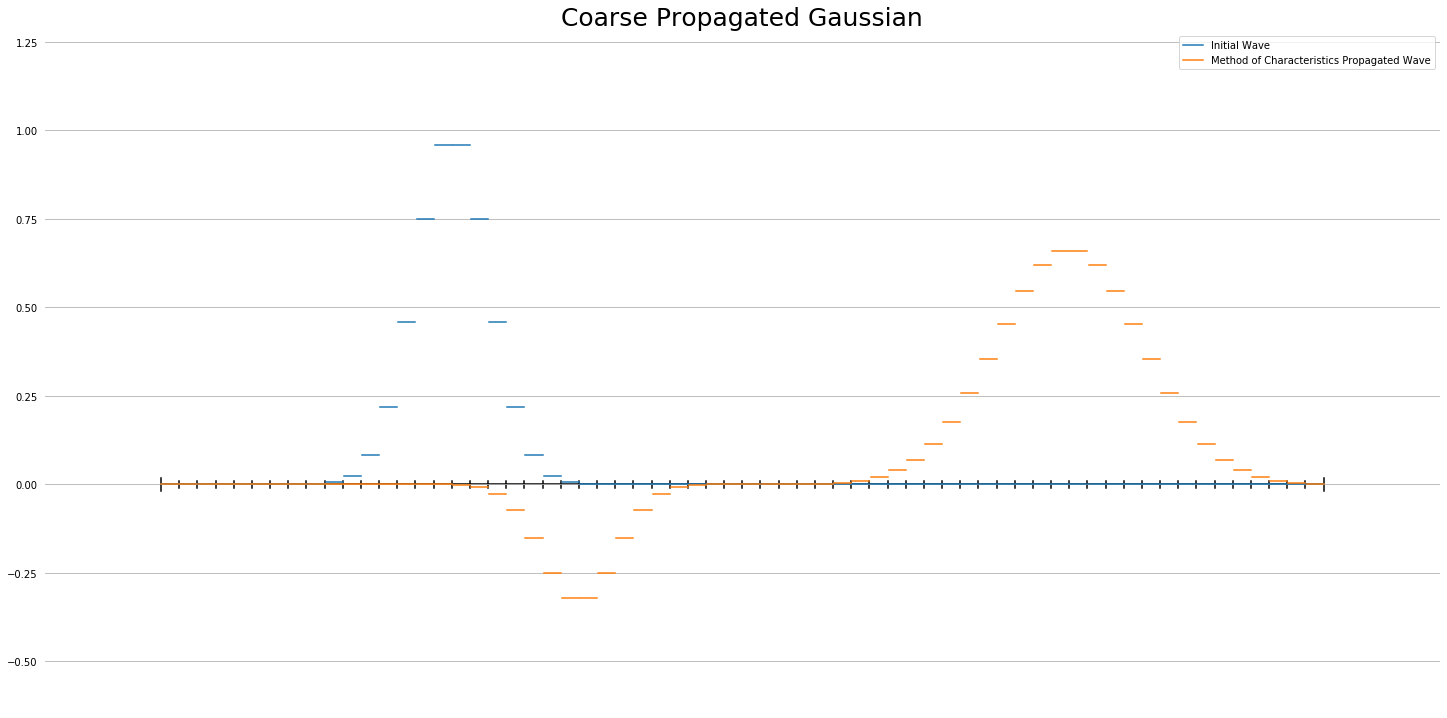

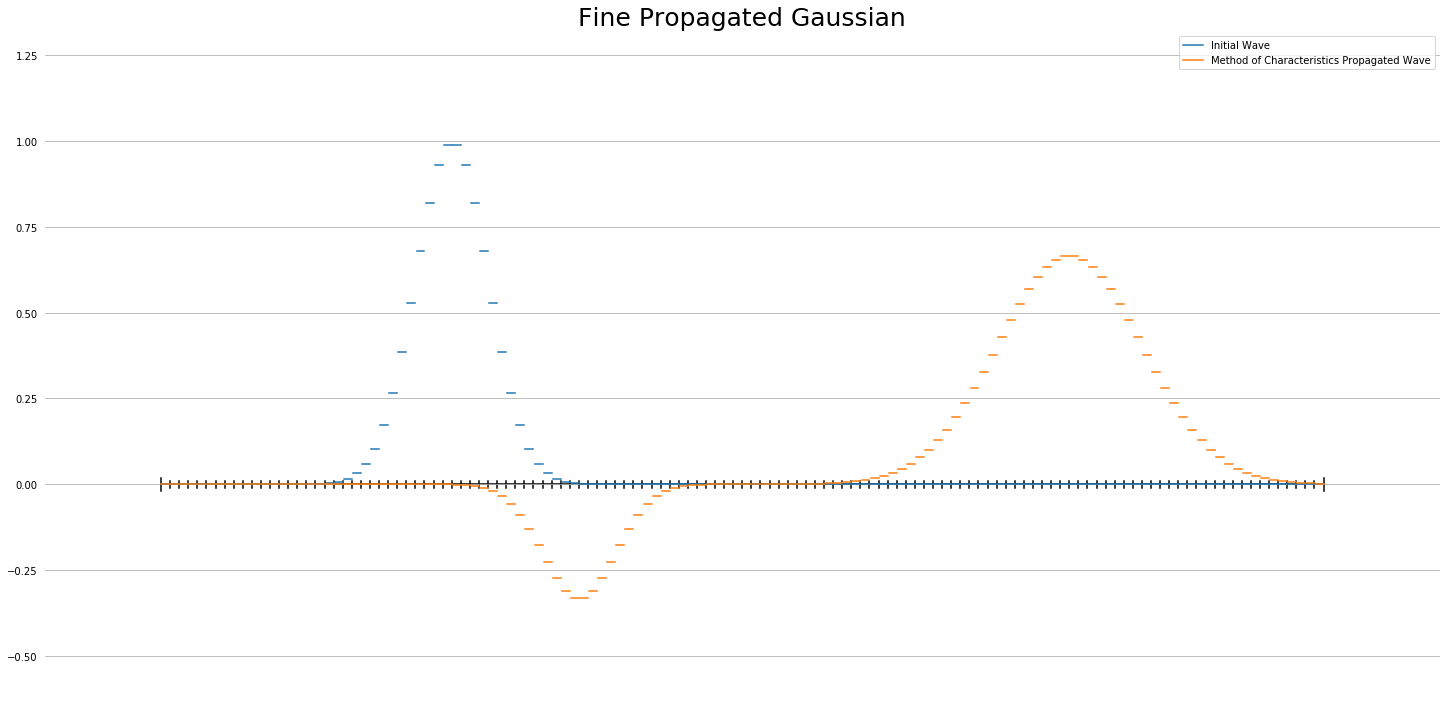

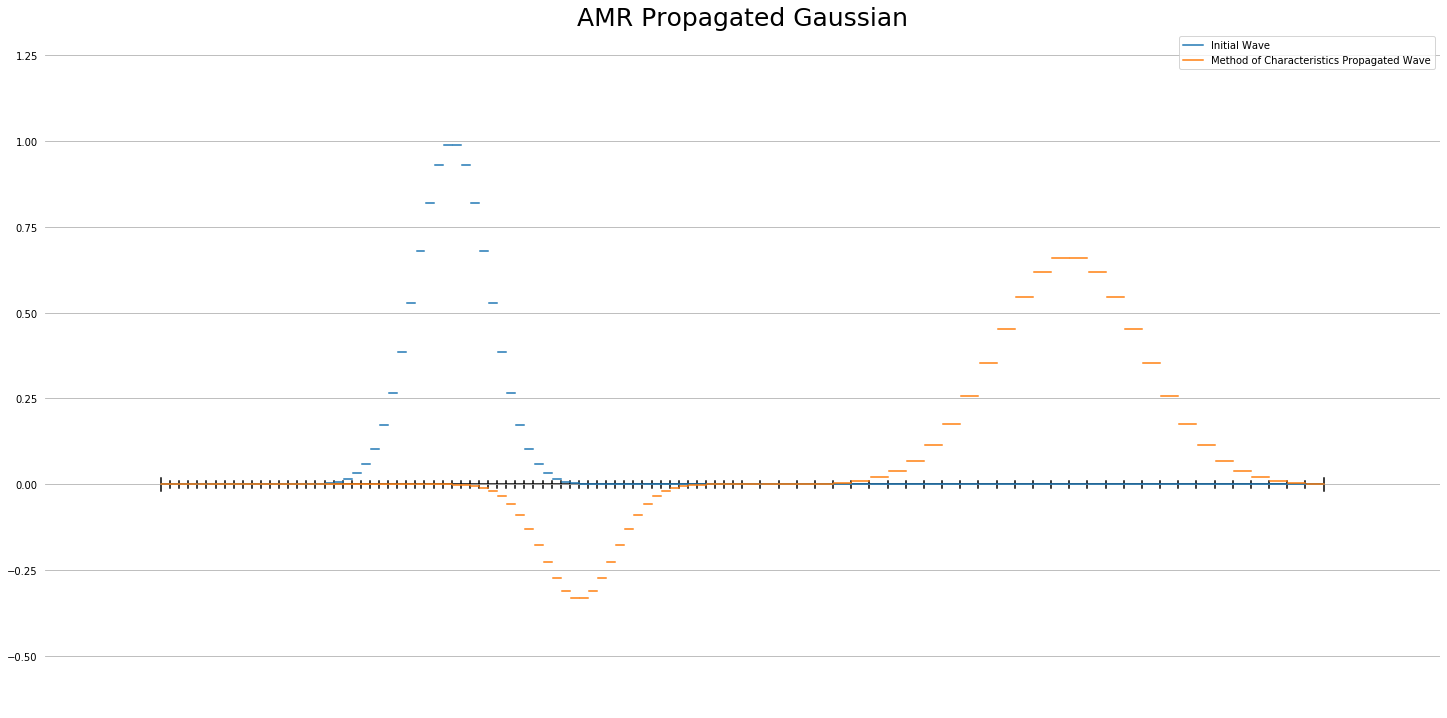

In [12]:
PT.PlotMixedWave(omegaC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, title = 'Coarse Propagated Gaussian', saveName = title + 'Coarse', dpi = 300, plotCont = plotCont)
PT.PlotMixedWave(omegaF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True, labels = labels, title = 'Fine Propagated Gaussian', saveName = title + 'Fine', dpi = 300, plotCont = plotCont)#, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
PT.PlotMixedWave(omegaAMR, waves = wavesAMR, FCoefs = allCoefsAMR, rescale = 5, yGrid = True, labels = labels, title = 'AMR Propagated Gaussian', saveName = title + 'AMR', dpi = 300, plotCont = plotCont)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


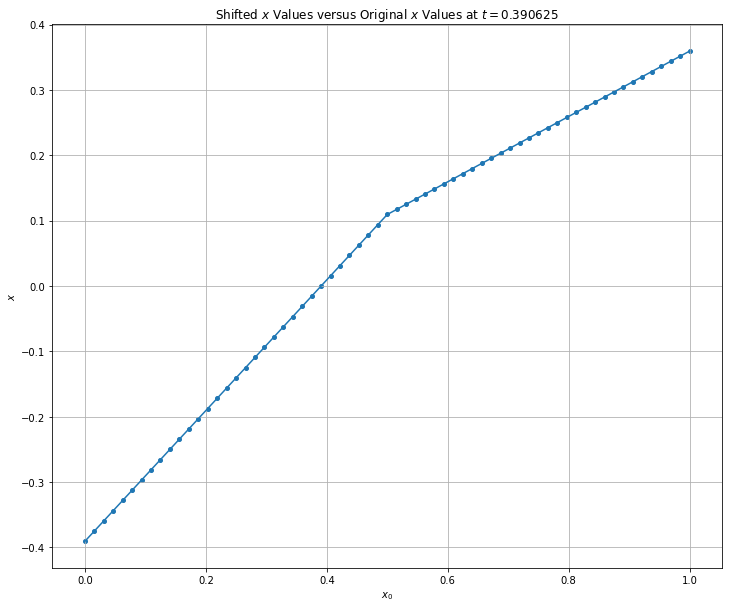

In [13]:
x_0vec = omegaC.xNode
xShift = WFT.ShiftX(omegaC, physicsC, t)
fig, ax = plt.subplots(figsize = [12, 10])
plt.plot(x_0vec, xShift)
plt.scatter(x_0vec, xShift, s = 16)
plt.title(r'Shifted $x$ Values versus Original $x$ Values at $t = %f$' %t)
plt.xlabel(r'$x_{0}$')
plt.ylabel(r'$x$')
ax.grid(True, zorder = 0)
saveName = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/xvsx_0_' + str(nt)# + appendage
# fig.savefig(saveName + '.png', bbox_inches = 'tight')
plt.show()